In [8]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns



Justificativa:

    ucimlrepo nos dá acesso direto à base CDC.

    scikit-learn contém as ferramentas de particionamento, pré-processamento e KNN.

    matplotlib e seaborn para visualizações.

In [9]:
# 2.1 Fetch do dataset CDC Diabetes (UCI ID 891)
cdc = fetch_ucirepo(id=891)

# 2.2 Separação de features (X) e target (y)
X = cdc.data.features.copy()
y = cdc.data.targets.squeeze()  # transforma em Series para facilidade

print("Formato de X:", X.shape)
print("Distribuição de classes em y:\n", y.value_counts(normalize=True))

Formato de X: (253680, 21)
Distribuição de classes em y:
 Diabetes_binary
0    0.860667
1    0.139333
Name: proportion, dtype: float64


Justificativa na seleção de variáveis:
Para esta etapa inicial, utilizamos todas as colunas disponíveis, pois indicadores clínicos (IMC, pressão, colesterol) e comportamentais (atividade, dieta) têm potencial preditivo relevante.

In [10]:
# 3.1 Split com stratify para manter proporção de classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Treino:", X_train.shape, "Teste:", X_test.shape)
print("Proporção treino:", y_train.value_counts(normalize=True).round(3))
print("Proporção teste:", y_test.value_counts(normalize=True).round(3))

Treino: (202944, 21) Teste: (50736, 21)
Proporção treino: Diabetes_binary
0    0.861
1    0.139
Name: proportion, dtype: float64
Proporção teste: Diabetes_binary
0    0.861
1    0.139
Name: proportion, dtype: float64


Por que estratificar?
Quando há desequilíbrio (muito mais não-diabéticos do que diabéticos), a estratificação garante que a proporção de cada classe seja mantida em treino e teste, evitando viés de avaliação.

In [11]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Colunas numéricas:", num_cols)
print("Colunas categóricas:", cat_cols)

Colunas numéricas: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
Colunas categóricas: []


In [12]:
# 4.2.1 Imputar mediana
imputer_num = SimpleImputer(strategy='median')
X_train_num = imputer_num.fit_transform(X_train[num_cols])
X_test_num  = imputer_num.transform(   X_test[num_cols])

# 4.2.2 Escalar para média 0 e desvio 1
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num)
X_test_num  = scaler.transform(   X_test_num)

Por que normalizar?
O KNN calcula distâncias entre pontos; se uma feature tem escala muito maior, ela domina o cálculo de proximidade e distorce o modelo.

In [14]:
# 4.3 Imputação e codificação das variáveis categóricas
import numpy as np

if len(cat_cols) > 0:
    # 4.3.1 Imputar valor mais frequente
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X_train_cat = imputer_cat.fit_transform(X_train[cat_cols])
    X_test_cat  = imputer_cat.transform(   X_test[cat_cols])

    # 4.3.2 One-Hot Encoding
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    X_train_cat = encoder.fit_transform(X_train_cat)
    X_test_cat  = encoder.transform(   X_test_cat)

    print("Dimensões após encoding:", X_train_cat.shape, X_test_cat.shape)

else:
    # Caso não existam colunas categóricas
    X_train_cat = np.empty((X_train.shape[0], 0))
    X_test_cat  = np.empty((X_test.shape[0], 0))
    print("Nenhuma coluna categórica para processar.")

Nenhuma coluna categórica para processar.


In [15]:
# Concatena numéricas e categóricas
X_train_proc = np.hstack([X_train_num, X_train_cat])
X_test_proc  = np.hstack([X_test_num,  X_test_cat])

print("Dimensões finais treino:", X_train_proc.shape)


Dimensões finais treino: (202944, 21)


In [ ]:
# Concatena numéricas e categóricas
X_train_proc = np.hstack([X_train_num, X_train_cat])
X_test_proc  = np.hstack([X_test_num,  X_test_cat])

print("Dimensões finais treino:", X_train_proc.shape)


Dimensões finais treino: (202944, 21)


In [17]:
# 6.1 Treinar com k=5 inicialmente
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train_proc, y_train)

# 6.2 Predição e relatório
y_pred5 = knn5.predict(X_test_proc)
print("Desempenho KNN (k=5):")
print(classification_report(y_test, y_pred5))
print("Acurácia:", accuracy_score(y_test, y_pred5))


Desempenho KNN (k=5):
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     43667
           1       0.41      0.22      0.28      7069

    accuracy                           0.85     50736
   macro avg       0.65      0.58      0.60     50736
weighted avg       0.82      0.85      0.83     50736

Acurácia: 0.8475835698517817


Observação inicial:
Este resultado serve de baseline antes de ajustarmos k.

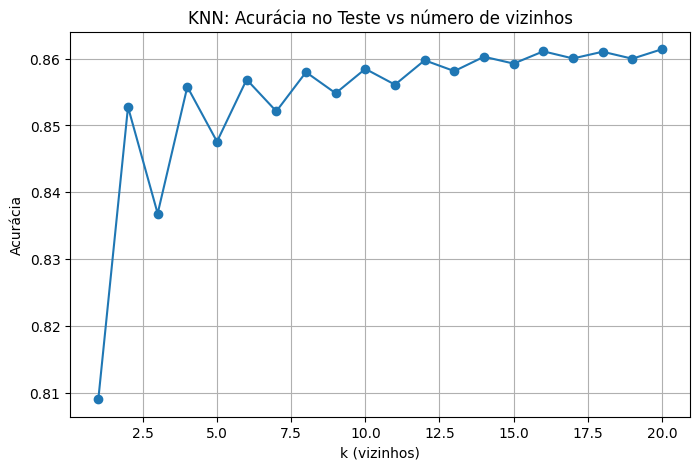

Melhor k: 20 com acurácia 0.8614


In [18]:
ks = list(range(1, 21))
accuracies = []

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_proc, y_train)
    pred = knn.predict(X_test_proc)
    accuracies.append(accuracy_score(y_test, pred))

# Plot da curva de acurácia vs k
plt.figure(figsize=(8,5))
plt.plot(ks, accuracies, marker='o')
plt.title('KNN: Acurácia no Teste vs número de vizinhos')
plt.xlabel('k (vizinhos)')
plt.ylabel('Acurácia')
plt.grid(True)
plt.show()

best_k = ks[np.argmax(accuracies)]
print(f"Melhor k: {best_k} com acurácia {max(accuracies):.4f}")


Discussão:

    Valores pequenos de k tendem a capturar ruído (alta variação).

    Valores grandes suavizam demais (alto viés).

    Escolhemos o k que maximiza a acurácia sem complicar a fronteira de decisão.

In [19]:
# 8.1 Treinar modelo final com o k ótimo
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_proc, y_train)

# 8.2 Avaliação final
y_pred_final = knn_final.predict(X_test_proc)
print("Desempenho Final do KNN:")
print(classification_report(y_test, y_pred_final))
print("Acurácia Final:", accuracy_score(y_test, y_pred_final))


Desempenho Final do KNN:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92     43667
           1       0.51      0.11      0.17      7069

    accuracy                           0.86     50736
   macro avg       0.69      0.54      0.55     50736
weighted avg       0.82      0.86      0.82     50736

Acurácia Final: 0.8614001892147588
